# Here we build our dictionary and train our model

Using the candidates and parties preprocessed tweets as our labeled dataset

In [1]:
# Libs
import csv
import string
import numpy as np
import time
import sys
import nltk
import random
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from nltk.tokenize import word_tokenize

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

In [ ]:
import libs.bag_of_worder as bag_of_worder
import libs.preprocessor as tweet_preproc

# Init Preprocessor
twitterPreprocessor = tweet_preproc.TwitterPreprocessor()

# Dataset

IMPORTANT, the label should have only two states 0: dems, 1: republican

In [3]:
def load_dataset(path):
    
    x = []
    y = []

    with open(path, 'r', newline='', encoding="utf-8") as csvfile:
        
        reader = csv.reader(csvfile, quotechar='"', delimiter=',')
        
        # Taking the header of the file + the index of useful columns:
        header = next(reader)
        ind_label = header.index('label')
        ind_text = header.index('text')
        
        for row in reader:
            
            label = row[ind_label]
            if label == "democrat":
                y.append(0)
            elif label == "republican":
                y.append(1)
            else:
                continue
                
            x.append(row[ind_text])
            

        assert len(x) == len(y)

        return x, y

In [4]:
def checkBalanced(labels):
    return np.count_nonzero(labels)/len(labels)


def balance_dataset(features, labels):
    
    # Combine the features with the labels
    combined = list(zip(features, labels))
    
    # Shuffle the list
    random.shuffle(combined)

    # Split the feature and label
    X[:], y[:] = zip(*combined)
    
    # Count number of '1'
    nbrOfOnes = np.count_nonzero(y)
    nbrOfZeros = len(y) - nbrOfOnes
    excessNbr = abs(nbrOfOnes - nbrOfZeros)
    
    # Balance dataset
    removed_counter = 0
    if(nbrOfOnes > nbrOfZeros):  # too much '1'

        for ind in range(0,len(y)):
            if(y[ind] == 1):
                X.pop(ind)
                y.pop(ind)
                removed_counter = removed_counter + 1
                
            if(removed_counter >= abs(excessNbr)):
                break

    else:                       # too much '0'

        for ind in range(0,len(y)):
            if(y[ind] == 0):
                X.pop(ind)
                y.pop(ind)
                removed_counter = removed_counter + 1
                
            if(removed_counter >= abs(excessNbr)):
                break
            
    return X, y

In [5]:
# Path of the labeled dataset
path = "data/parties_candidates/sources.csv"

# Load dataset from path
X, y = load_dataset(path)

# Make sure there is 50/50 of both labels
X, y = balance_dataset(X,y)

# Split the data
train_X, valid_X, train_Y, valid_Y = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True, stratify=y)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))

Length of training set :  93948
Length of validation set :  23488


In [6]:
# Make sure the training data is balanced
print("--- Proportion of republican label ---")
print(checkBalanced(train_Y))

--- Proportion of republican label ---
0.5


# Review Length in Words
Inspired from: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [7]:
# Summarize number of classes
print("Classes: ")
print(np.unique(train_Y))

Classes: 
[0 1]


In [9]:
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(train_X))))

Number of words: 
66697


Review length: 
Mean 73.82 words (24.985910)


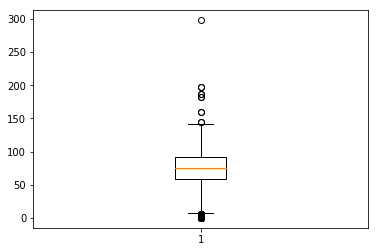

In [10]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in train_X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
fig = plt.figure()
plt.boxplot(result)
plt.show()
fig.savefig('results/data_length_review.pdf', bbox_inches='tight')

# Dictionary

In [9]:
def bigram(tokens):
    """
    tokens: a list of strings
    """
    # Init array
    bigrams = []
    
    # Go through tokens
    for i in range(0,len(tokens)-1):
        bigrams.append(" ".join([tokens[i],tokens[i+1]]))
    
    # This function returns the list of bigrams
    return bigrams


# Returns unique words
def buildDict(tweets, addBigram=False):
    
    # Init empty set
    wordDict = set()
    
    # Go through each tweet of the validation set
    for tweet in tweets:

        # Tokenize
        words = word_tokenize(tweet)
        
        # Add Bigram
        if(addBigram):
            words = words + bigram(words)

        # Go through each word
        for word in words:

            # Append to dictionary if not already there
            if(word not in wordDict):
                wordDict.add(word)
                
    # Get the stats
    print("Dict Dimension: " + str(len(wordDict)))
    
    return list(wordDict)


def loadDict():
    
    # Init dict
    wordDict = []
    
    path = "model/dictionary.txt"
    with open(path, 'r', newline='', encoding="utf-8") as input_file:    
        for row in input_file:
            wordDict.append(row.strip())
            
    # Get the stats
    print("Dict Dimension: " + str(len(wordDict)))
            
    return wordDict

In [10]:
# Create a dictionary of all the words
wordDict = loadDict()

Dict Dimension: 25890


## Dictionary Reduction

In [ ]:
def reduceDict(wordDict,countBoW,tweets):

    # Init the BoW Matrix
    matrixBoW = np.zeros((1, len(wordDict)),dtype=np.int16)

    for tweet in tqdm(tweets):

        # Compute the BoW
        bowObject = countBoW.computeLine(tweet)

        # Add to matrixBoW
        matrixBoW = np.add(matrixBoW,bowObject)


    # Only keep words that occured more than once
    newWordDict = []
    for ind in np.argwhere(matrixBoW > 1):
        newWordDict.append(wordDict[ind[1]])

    reduction = len(newWordDict)/(1.0*len(wordDict))
    print(reduction)

    
    # Write to file
    path = "model/dictionary_new.txt"
    with open(path, 'w+', newline='', encoding="utf-8") as output_file:
        for word in newWordDict:
            output_file.write(str(word) + "\n")
            
    print("New dictionary created!")

In [ ]:
# reduceDict(wordDict,countBoW,train_X)

# Classifier

In [11]:
from joblib import dump, load

# Load Model
def loadModel():
    
    try:
        classifier = load('model/logistic.joblib') 
        print("Model Loaded!")
        return classifier
    
    except:
        print("ERROR: Model not saved")
        
        
def saveModel(clf):

    dump(clf, 'model/logistic.joblib') 

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def train_evaluate(training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    classifier = LogisticRegression(n_jobs=-1,solver='lbfgs', multi_class='auto')

    training_rep = bowObj.computeMatrix(training_X)

    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validationAcc = accuracy_score(
        validation_Y, classifier.predict(bowObj.computeMatrix(validation_X)))

    return classifier, trainAcc, validationAcc


In [ ]:
# Init Bag-of-Worder using the dictionary
countBoW = bag_of_worder.BagOfWorder(wordDict)

# Train
classifier, trainAcc, validationAcc = train_evaluate(train_X,train_Y,valid_X,valid_Y,countBoW)
print("Training Accuracy: " + str(trainAcc))
print("Validation Accuracy: " + str(validationAcc))

In [ ]:
# Save Model
saveModel(classifier)

In [ ]:
def checkPerf(classifier, countBoW):
    
    # Check performance
    preds = classifier.predict(countBoW.computeMatrix(train_X[1:4]))
    np.count_nonzero(np.equal(preds,train_Y))/len(preds)

## Training and testing models
Codes copied from: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

### Transforming data

In [63]:
top_words = 5000

In [22]:
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_X)

train_X_t = tokenizer.texts_to_sequences(train_X)
valid_X_t = tokenizer.texts_to_sequences(valid_X)

In [23]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

train_X_t = pad_sequences(train_X_t, padding='post', maxlen=maxlen)
valid_X_t = pad_sequences(valid_X_t, padding='post', maxlen=maxlen)

print('vocab_size: {}'.format(vocab_size))

vocab_size: 32097


In [31]:
train_X_t[3]

array([  59,    2,  187, 1246, 2133, 2018,  893,  784,  473,   90, 1709,
        677,    2, 3229,  134,    3,  141,  745,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

### Random Forest algorithm
Here, we don't need any normalization.

In [24]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(train_X_t, train_Y)

c:\program files\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [25]:
predictions = text_classifier.predict(valid_X_t)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(valid_Y, predictions))
print(classification_report(valid_Y, predictions))
print(accuracy_score(valid_Y, predictions))

[[10192  1552]
 [ 2147  9597]]
             precision    recall  f1-score   support

          0       0.83      0.87      0.85     11744
          1       0.86      0.82      0.84     11744

avg / total       0.84      0.84      0.84     23488

0.8425153269754768


### Logistic Regression algorithm

In [32]:
from sklearn.preprocessing import MinMaxScaler
# Normalize data
scaler = MinMaxScaler()
train_X_t_n = scaler.fit_transform(train_X_t)
valid_X_t_n = scaler.transform(valid_X_t)

c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
from sklearn.linear_model import LogisticRegression

text_classifier = LogisticRegression()
text_classifier.fit(train_X_t, train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
predictions = text_classifier.predict(valid_X_t)

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(valid_Y, predictions))
print(classification_report(valid_Y, predictions))
print(accuracy_score(valid_Y, predictions))

[[4706 7038]
 [3527 8217]]
             precision    recall  f1-score   support

          0       0.57      0.40      0.47     11744
          1       0.54      0.70      0.61     11744

avg / total       0.56      0.55      0.54     23488

0.5501958446866485


### SVM algorithm

In [42]:
from sklearn import svm

text_classifier = svm.SVC(gamma='auto')
text_classifier.fit(train_X_t_n, train_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
predictions = text_classifier.predict(valid_X_t_n)

In [44]:
print(confusion_matrix(valid_Y, predictions))
print(classification_report(valid_Y, predictions))
print(accuracy_score(valid_Y, predictions))

[[2550 9194]
 [1838 9906]]
             precision    recall  f1-score   support

          0       0.58      0.22      0.32     11744
          1       0.52      0.84      0.64     11744

avg / total       0.55      0.53      0.48     23488

0.5303133514986376


In [45]:
dump(text_classifier, 'model/svm_svc.joblib')

['model/svm_svc.joblib']

### Simple Neural Network
Inspired from: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [88]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               800250    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 251       
Total params: 960,501
Trainable params: 960,501
Non-trainable params: 0
_________________________________________________________________
None


In [89]:
history = model.fit(train_X_t, train_Y, batch_size=128, epochs=5, verbose=2, validation_split=0.2)

Train on 75158 samples, validate on 18790 samples
Epoch 1/5
 - 3s - loss: 0.3315 - acc: 0.8461 - val_loss: 0.2466 - val_acc: 0.8957
Epoch 2/5
 - 2s - loss: 0.1941 - acc: 0.9215 - val_loss: 0.2318 - val_acc: 0.9063
Epoch 3/5
 - 2s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.2356 - val_acc: 0.9119
Epoch 4/5
 - 2s - loss: 0.0916 - acc: 0.9658 - val_loss: 0.2636 - val_acc: 0.9133
Epoch 5/5
 - 2s - loss: 0.0656 - acc: 0.9764 - val_loss: 0.3005 - val_acc: 0.9155


In [90]:
model.save('model/dl_snn.h5')

In [91]:
score = model.evaluate(valid_X_t, valid_Y, verbose=0)

print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 0.30050905183787463
Test Accuracy: 0.9119550408719346


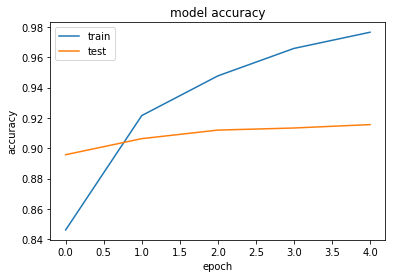

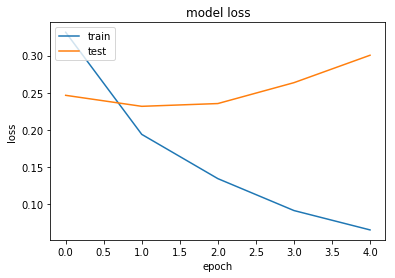

In [92]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
fig.savefig('results/dl_snn_train_curve_acc.pdf', bbox_inches='tight')

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
fig.savefig('results/dl_snn_train_curve_loss.pdf', bbox_inches='tight')

In [93]:
predictions = model.predict(valid_X_t)

In [95]:
print(confusion_matrix(valid_Y, predictions.round()))
print(classification_report(valid_Y, predictions.round()))
print(accuracy_score(valid_Y, predictions.round()))

[[10798   946]
 [ 1122 10622]]
             precision    recall  f1-score   support

          0       0.91      0.92      0.91     11744
          1       0.92      0.90      0.91     11744

avg / total       0.91      0.91      0.91     23488

0.9119550408719346


### One-Dimensional Convolutional Neural Network Model
Inspired from: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [96]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [102]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 32)           160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 250)               400250    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 251       
Total params: 563,605
Trainable params: 563,605
Non-trainable params: 0
_________________________________________________________________


In [103]:
history = model.fit(train_X_t, train_Y, batch_size=128, epochs=5, verbose=2, validation_split=0.2)

Train on 75158 samples, validate on 18790 samples
Epoch 1/5
 - 3s - loss: 0.3250 - acc: 0.8474 - val_loss: 0.2496 - val_acc: 0.8955
Epoch 2/5
 - 3s - loss: 0.1931 - acc: 0.9203 - val_loss: 0.2193 - val_acc: 0.9104
Epoch 3/5
 - 3s - loss: 0.1297 - acc: 0.9499 - val_loss: 0.2179 - val_acc: 0.9172
Epoch 4/5
 - 3s - loss: 0.0789 - acc: 0.9712 - val_loss: 0.2454 - val_acc: 0.9226
Epoch 5/5
 - 3s - loss: 0.0467 - acc: 0.9836 - val_loss: 0.2835 - val_acc: 0.9251


In [104]:
model.save('model/dl_cnn.h5')

In [105]:
score = model.evaluate(valid_X_t, valid_Y, verbose=0)

print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 0.29008527080324154
Test Accuracy: 0.9208957765667575


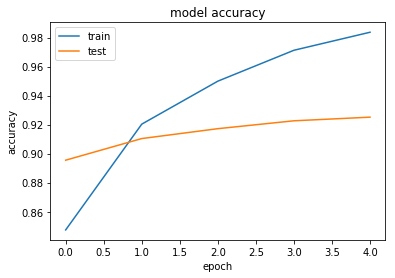

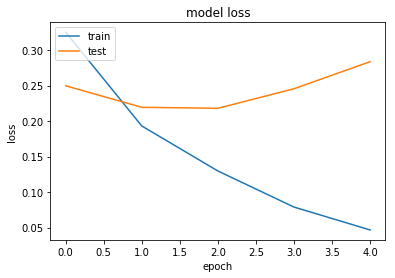

In [106]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
fig.savefig('results/dl_cnn_train_curve_acc.pdf', bbox_inches='tight')

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
fig.savefig('results/dl_cnn_train_curve_loss.pdf', bbox_inches='tight')

In [107]:
predictions = model.predict(valid_X_t)

In [108]:
print(confusion_matrix(valid_Y, predictions.round()))
print(classification_report(valid_Y, predictions.round()))
print(accuracy_score(valid_Y, predictions.round()))

[[11001   743]
 [ 1115 10629]]
             precision    recall  f1-score   support

          0       0.91      0.94      0.92     11744
          1       0.93      0.91      0.92     11744

avg / total       0.92      0.92      0.92     23488

0.9208957765667575
